# Simple Case Using Only the Default Dataset and Quantum Kernel Model

In this tutorial, you will learn how to manage experiments in quantum machine learning using QXMT's default features with quantum kernel models. QXMT offers commonly used datasets, preprocessing methods, quantum machine learning models, and evaluation metrics as part of its default functionality. By leveraging these built-in features, you can efficiently establish a baseline during the early stages of your experiments.

QXMT manages experiments by the following directory structure:

- **data**: Contains the raw data used in the experiments.
- **config**: Holds YAML files that define the configurations for each experiment run.
- **experiments**: Contains the information and results of experiments, which are incrementally saved by the program. Each folder is organized by the name of the experiment (to be explained later) and includes individual "run" folders that store the actual execution results.


``` bash
<your_project>
├── data
├── configs
│   ├── config_1.yaml
│   ├──   ⋮
│   └── config_n.yaml
└── experiments
    ├── <your_experiment_1>
    │   ├── experiment.json
    │   ├── run_1
    │   │   ├── config.yaml
    │   │   ├── shots.h5
    │   │   └── model.pkl
    │   ├── run_2
    │   ├──   ⋮
    │   └── run_n
    │   ⋮
    └── <your_experiment_n>
```

## 1. Experiment Setup
First, import the packages installed via pip. Then, create an `Experiment` instance to manage the entire experiment and initialize it using the `init()` method. The `Experiment` class allows several member variables to be specified, but for now, we will configure just the basic three. Each has the following roles:

- **name**: Sets the name of the experiment. A directory `experiments/{name}` will be created in the current working directory based on this name.
- **desc**: A free-text field for adding a brief description of the experiment. It is not used in any processing, and there are no restrictions other than being a string. Use this field to document any relevant information for reviewing the experiment later.
- **auto_gen_mode**: A flag to enable or disable the feature that automatically generates descriptions for each run using an LLM (default is `False`). If you want to use this feature, make sure to run `pip install qxmt[llm]` when installing the package, and set the environment variable `USE_LLM` to `True`.

In [1]:
import qxmt

experiment = qxmt.Experiment(
    name="simple_tutorial",
    desc="A simple experiment to check the operation of the QXMT library",
    auto_gen_mode=False,
).init()

Up to this point, we have completed the setup for managing experiments using QXMT.

## 2. Run Configuration
In QXMT, each experimental trial is managed as a unit called a "Run." There are two methods to configure a Run: by directly passing instances, such as datasets and models, to the `experiment.run()` method, or by using a YAML configuration file. While the instance-based method is convenient for ad-hoc validations due to its simplicity, for more structured experimental management, especially in research, we recommend using the more feature-rich config-based method.

In this section, we will explain the configuration items based on the config file used in this tutorial.

- **description**: Provides a description for the Run. The description defined in "1. Experiment Setup" applies to the entire experiment, while this description is specific to the Run. If this field is left empty and `auto_gen_mode=True`, a description will be automatically generated by an LLM.
- **dataset**: Specifies the dataset to be used for the run. The `type` can be either "file", "generate" or "openml". If "file" is specified, a dataset that you have prepared will be used. If "generate" is specified, dummy data will be generated. If "openml" is specified, target dataset download by using OpenML API. In this tutorial, we will use the "generate" mode, but the "file" mode, which is more applicable to real-world scenarios, is covered in another tutorial.
- **global_settings**: Defines global configuration parameters including:
  - `random_seed`: Sets a seed for reproducibility
  - `model_type`: Must be set to "qkernel" for quantum kernel models
  - `task_type`: For quantum kernel models, specifies whether the task is "classification" or "regression"
- **device**: Configures the quantum device for running simulations. Currently, config-based settings support only PennyLane.
- **feature_map**: If using a quantum feature map, specify the module name (`module_name`) and class name (`implement_name`) where the feature map is implemented. Any required parameters can be specified in `params` as a dictionary. In this tutorial, we will use the default feature maps provided.
- **kernel**: If using a kernel-based model, specify the module name (`module_name`) and class name (`implement_name`) where the kernel is implemented. Required parameters can be specified in `params` as a dictionary. In this tutorial, we will use the default kernel provided.
- **model**: Specifies the machine learning model to be used, along with its parameters. For quantum kernel models, available options include "qsvc" (for classification), "qsvr" (for regression), and "qrigge" (for regression).
- **evaluation**: Lists the evaluation metrics to be used, chosen from the default set of metrics provided.

``` yaml
description: "Configuration file for the simple example"

global_settings:
  random_seed: &global_seed 42
  model_type: "qkernel"
  task_type: "classification"

dataset:
  generate:
    generate_method: "linear"
    params: {
      "n_samples": 100,
      "n_features": 2,
      "n_classes": 2,
    }
  split:
    train_ratio: 0.8
    validation_ratio: 0.0
    test_ratio: 0.2
    shuffle: true
  features: null
  raw_preprocess_logic: null
  transform_logic: null

device:
  platform: "pennylane"
  device_name: "default.qubit"
  n_qubits: 2
  shots: null

feature_map:
  module_name: "qxmt.feature_maps.pennylane"
  implement_name: "ZZFeatureMap"
  params:
    reps: 2

kernel:
  module_name: "qxmt.kernels.pennylane"
  implement_name: "FidelityKernel"
  params: {}

model:
  name: "qsvc"
  params:
    C: 1.0
    gamma: 0.05

evaluation:
  default_metrics:
  - "accuracy"
  - "precision"
  - "recall"
  - "f1_score"
  custom_metrics: []
```

## 3. Executing the "Run"
In this step, you will execute the "Run" (Experiment) configured in Step 2. There are two methods to execute a Run: by passing the configuration as a file path or by passing it as an instance. First, we will demonstrate how to execute it by specifying the file path.


In [2]:
config_path = "../configs/simple.yaml"

# input config file
artifact_1, result_1 = experiment.run(config_source=config_path)

Output()

Output()

When executing a Run, you can specify various additional arguments, but in this case, we will introduce the simplest method. When a Run is executed, it returns an `artifact` and a `result`. The `artifact` includes the dataset (`artifact.dataset`) and machine learning model (`artifact.model`) used in the Run. The `result` contains the Run settings and model evaluation results. These can be used for visualization, as introduced in the next chapter, or for analysis during subsequent model development.

Next, we will demonstrate how to execute a Run by passing the configuration as an instance. This method is useful for making on-the-fly adjustments to model parameters and is particularly beneficial when exploring the structure of a model.

In [3]:
from qxmt import ExperimentConfig

# load default config
adhoc_config = ExperimentConfig(path=config_path)

# update model paramter
adhoc_config.model.params.update(
    {"C": 0.5, "gamma": "scale"})

# input the updated config instance
artifact_2, result_2 = experiment.run(config_source=adhoc_config)

Output()

Output()

The `artifact` and `result` obtained from the execution will have the same format as those generated when running from a configuration file.

The results of each Run can be retrieved as a DataFrame containing the metrics specified in `evaluation.default_metrics` by executing the following code:

In [4]:
# extract the results as a pandas dataframe
metrics_df = experiment.runs_to_dataframe()

metrics_df.head()

,run_id,accuracy,precision,recall,f1_score
0,1,0.60,0.555556,0.555556,0.555556
1,2,0.55,0.500000,0.444444,0.470588


## 4. Visualization of Results
This section introduces several methods for visualizing the results of multiple Runs managed by the Experiment. In addition to the techniques introduced here, the library provides various other visualization options. Please refer to the API Reference and use the methods that best suit your objectives. Additionally, the results of a Run, stored in the `result` from the previous chapter, can be extracted as a DataFrame, allowing you to perform your own analyses and visualizations.

### 4.1 Visualizing the Label Distribution of the Dataset
In this section, we visualize the label distribution of the dummy dataset created. This allows you to visually inspect whether there are significant deviations in the distribution between the training and evaluation datasets. In the following example, only the dataset and the save path (`save_path`) are specified as arguments, but other options, such as the graph title, can also be passed as `kwargs`. Additionally, if `save_path=None` is specified, the graph will not be saved.

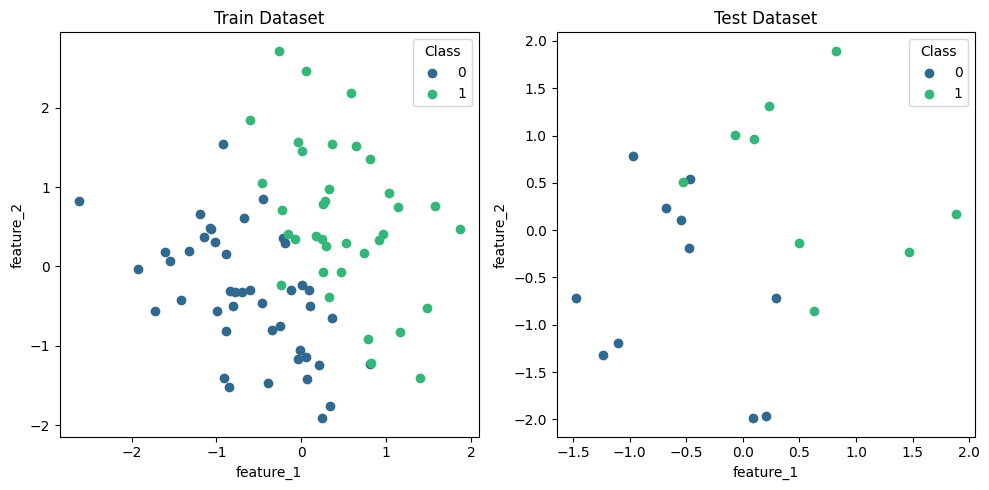

In [5]:
from qxmt.visualization import plot_2d_dataset

# extract dataset instance from run artifact
dataset = artifact_1.dataset

plot_2d_dataset(
  dataset=dataset,
  save_path=experiment.experiment_dirc / f"run_{experiment.current_run_id}/dataset.png"
  )

### 4.2 Comparison of Evaluation Metrics
In this section, we explain how to visualize and compare evaluation metrics when multiple Runs are executed with different parameters or model structures. Using `plot_metrics_side_by_side`, you can create bar graphs with each Run on the X-axis by passing a list of the evaluation metric names you want to compare (these correspond to the column names in the DataFrame). Additionally, although not used in this example, if you want to narrow the comparison to specific Runs, you can do so by passing a list of target `run_ids`, such as `run_ids=[1, 3, 5, 6]`, as an argument.

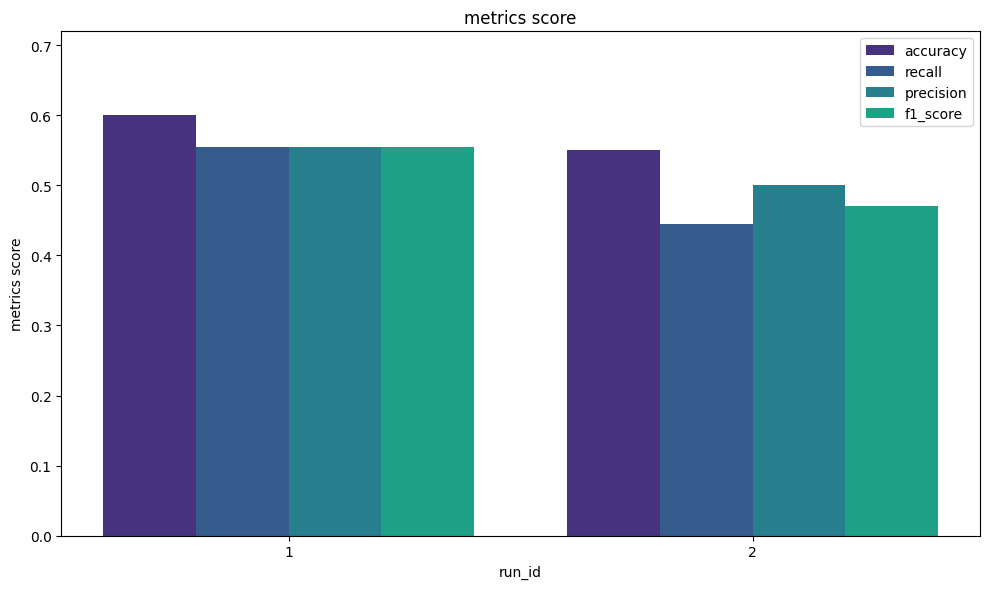

In [6]:
from qxmt.visualization import plot_metrics_side_by_side

# get run result as dataframe
df = experiment.runs_to_dataframe()

plot_metrics_side_by_side(
  df=df,
  metrics=["accuracy", "recall", "precision", "f1_score"],
  run_ids=[1, 2],
  save_path=experiment.experiment_dirc / "side_by_side.png"
  )

### 4.3 Decision Boundary of the Model
When using a Quantum Support Vector Machine (QSVC) as the model, you can visualize the decision boundary of the trained model. This visualization helps identify examples that are not classified correctly and provides insights into the model's behavior.

The model and dataset to be used as arguments can be obtained from the Run's `artifact`. The `grid_resolution` parameter allows you to set the resolution of the visualized decision boundary—the higher the value, the smoother the boundary, enabling you to examine individual sample classification results in more detail. However, higher resolution significantly increases computation time, so adjust it according to your needs. The `support_vectors` argument accepts a boolean value and controls whether support vectors are highlighted with circles to improve visibility in the output graph.

Output()

Executing "plot_2d_decision_boundaries". This may take some time...


Output()

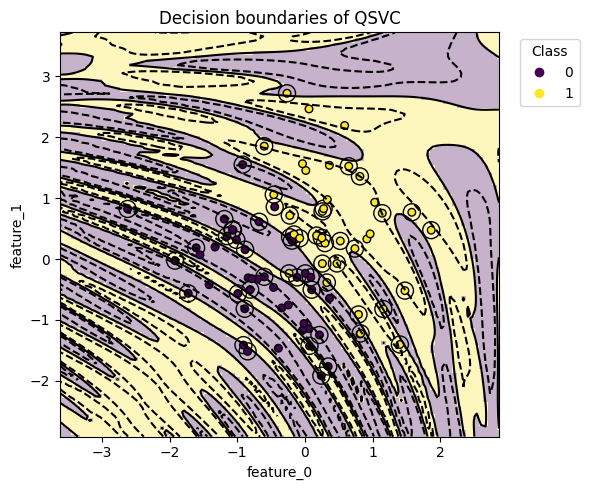

In [8]:
from qxmt.visualization import plot_2d_decision_boundaries

# extract model and dataset instance from run artifact
model = artifact_1.model
dataset = artifact_1.dataset

plot_2d_decision_boundaries(
  model=model,
  X=dataset.X_train,
  y=dataset.y_train,
  grid_resolution=100,
  support_vectors=True,
  save_path=experiment.experiment_dirc / f"run_{experiment.current_run_id}/boundary.png")

---

### Version Information
| Environment | Version |
|----------|----------|
| document | 2025/05/12 |
| QXMT| v0.5.1 |